# RSI-PCA

In [2]:
import pandas as pd
import pandas_ta as ta
import numpy as np
from typing import List
import seaborn as sns
from scipy import linalg as la
import matplotlib.pyplot as plt


def pca_linear_model(x: pd.DataFrame, y: pd.Series, n_components: int, thresh: float= 0.01):
    # Center data at 0
    means = x.mean()
    x -= means
    x = x.dropna()

    # Find covariance and compute eigen vectors
    cov = np.cov(x, rowvar=False)
    evals , evecs = la.eigh(cov)
    # Sort eigenvectors by size of eigenvalue
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]

    # Create data set for model
    model_data = pd.DataFrame()
    for j in range(n_components):
         model_data['PC' + str(j)] = pd.Series( np.dot(x, evecs[j]) , index=x.index)
    
    cols = list(model_data.columns)
    model_data['target'] = y
    model_coefs = la.lstsq(model_data[cols], y)[0]
    model_data['pred'] = np.dot( model_data[cols], model_coefs)

    l_thresh = model_data['pred'].quantile(0.99)
    s_thresh = model_data['pred'].quantile(0.01)

    return model_coefs, evecs, means, l_thresh, s_thresh, model_data


def pca_rsi_model(
        ohlc: pd.DataFrame, rsi_lbs: List[int], train_size: int, step_size: int,  
        n_components: int = 2, lookahead: int = 6
):    
    rsis = pd.DataFrame()
    for lb in rsi_lbs:
        rsis[lb] = ta.rsi(ohlc['close'], lb)
    # for lb in rsi_lbs:
    #     macd_fast = lb
    #     macd_slow = lb*2
    #     macd_signal = abs(lb-3)+1
    #     macd = ta.macd(ohlc['close'], fast=macd_fast, slow=macd_slow, signal=macd_signal)
    #     macd_features = pd.DataFrame()
    #     macd_features['macd_line'] = macd['MACD_' + str(macd_fast) + '_' + str(macd_slow) + '_' + str(macd_signal)]
    #     macd_features['signal_line'] = macd['MACDs_' + str(macd_fast) + '_' + str(macd_slow) + '_' + str(macd_signal)]
    #     macd_features['histogram'] = macd['MACDh_' + str(macd_fast) + '_' + str(macd_slow) + '_' + str(macd_signal)]
    #     # macd_features.dropna()
    #     rsis[lb] = macd_features['macd_line']
    #     # rsis[lb] = macd_features['signal_line']
    #     # rsis[lb] = macd_features['histogram']

    # # ADX
    # adx_data = pd.DataFrame()
    # for lb in rsi_lbs:
    #     adx = ta.adx(ohlc['high'], ohlc['low'], ohlc['close'], length=lb)
    #     rsis[lb] = adx[f'ADX_{lb}']

    warm_up = max(rsi_lbs) * 2
    next_train = warm_up + train_size
    tar = np.log(ohlc['close']).diff(lookahead).shift(-lookahead)

    # Outputs
    model_pred = np.zeros(len(ohlc))
    long_thresh = np.zeros(len(ohlc))
    short_thresh = np.zeros(len(ohlc))
    signal = np.zeros(len(ohlc))

    model_pred[:] = np.nan
    long_thresh[:] = np.nan
    short_thresh[:] = np.nan

    rsi_means = None
    evecs = None
    model_coefs = None
    l_thresh = None
    s_thresh = None
    for i in range(next_train, len(ohlc)):
        if i == next_train:
            # Get RSI values in window, prevent future leak
            train_data = rsis.iloc[i - train_size: i + 1 - lookahead].copy()
            y = tar.reindex(train_data.index)
            
            model_coefs, evecs, rsi_means, l_thresh, s_thresh, _ =  pca_linear_model(train_data, y, n_components)
            next_train += step_size
        
        curr_row = rsis.iloc[i] - rsi_means
        vec = np.zeros(n_components)
        for j in range(n_components):
            vec[j] = np.dot(curr_row, evecs[j])
        curr_pred = np.dot(vec, model_coefs)

        model_pred[i] = curr_pred
        long_thresh[i] = l_thresh 
        short_thresh[i] = s_thresh
        if curr_pred > l_thresh:
            signal[i] = 1
        elif curr_pred < s_thresh:
            signal[i] = -1

    # Output dataframe
    output_df = pd.DataFrame(index=ohlc.index)
    output_df['pred'] = model_pred
    output_df['long_thresh'] = long_thresh
    output_df['short_thresh'] = short_thresh
    output_df['signal'] = signal
    # Keep signals normalized to -1 1
    output_df['signal'] = output_df['signal'].rolling(lookahead).mean()     
    return output_df


In [35]:
df = pd.read_csv("../../datasets/universe.csv")

In [54]:
raw_data = df[df['ticker'] == 'BTCUSDT'].copy()
# raw_data = df[df['ticker'] == 'ETHUSDT'].copy()
# raw_data = df[df['ticker'] == 'DOGEUSDT'].copy()
raw_data['datetime'] = pd.to_datetime(raw_data['datetime'], format="mixed")
raw_data = raw_data.set_index('datetime')
raw_data = raw_data.dropna()

Mean Target Above Long Threshold 0.0036490547300658234
Mean Target Below Short Threshold -0.004493517903060071
Profit Factor 1.3549676174018999


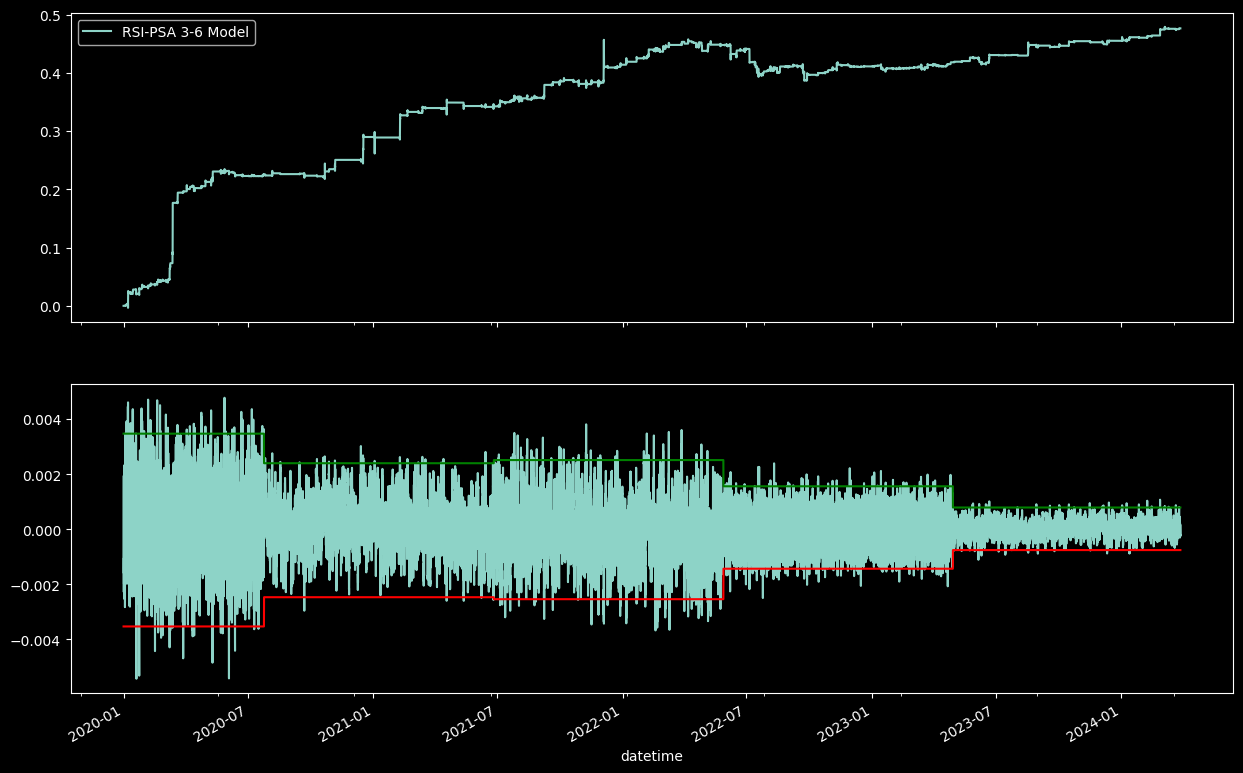

In [55]:
data = raw_data.copy()
# default
lookahead = 6
components = 3
# # default
# lookahead = 1
# components = 2
output = pca_rsi_model(data, list(range(2, 25)), 24 * 365*2, 24*7*4*12, n_components=3, lookahead=lookahead)
# output = pca_rsi_model(data, list(range(2, 25)), 24 * 365*2, 24 * 365/8, n_components=3, lookahead=lookahead)
# output = pca_rsi_model(data, list(range(2, 25)), 24 * 365 * 2, 24 * 365, n_components=3, lookahead=lookahead)
output['t'] = np.log(data['close']).diff(lookahead).shift(-lookahead)

print("Mean Target Above Long Threshold", output[output['pred'] > output['long_thresh']]['t'].mean())
print("Mean Target Below Short Threshold", output[output['pred'] < output['short_thresh']]['t'].mean())

next_r = np.log(data['close']).diff().shift(-1)
data['strat_ret'] = next_r * output['signal']

# Profit fac
pf = data[data['strat_ret'] > 0]['strat_ret'].sum() / data[data['strat_ret'] < 0]['strat_ret'].abs().sum()
print("Profit Factor",pf)


data['r'] = next_r

data = data[data.index > '2020-01-01']
output = output[output.index > '2020-01-01']

# plt.figure(figsize=(15, 10))  # You can adjust the numbers to fit your specific needs
plt.style.use('dark_background')

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15, 10))
data['strat_ret'].cumsum().plot(label='RSI-PSA 3-6 Model', ax=axs[0])

output['pred'].plot(ax=axs[1])
output['long_thresh'].plot(ax=axs[1], color='green')
output['short_thresh'].plot(ax=axs[1], color='red')
axs[0].legend()
# plt.show()  # This will display the plot

1.5107199885805942
1.5197828256661359
1.1429080879304778
1.2124443073368412
1.1804382117757863
1.0599449008823854
1.3252260058239689
1.3015233648237627
1.16591334538548
1.178867304421491
1.2043637828156881
1.1123440876163955
1.229083131524598
1.1540784461545333
1.0492161468087398
1.0989131436973822
1.0899635128306528
1.093250889550203
0.9711144874914793
1.1278230102843065
0.9209589082227703
0.9617819063556192
0.9273651646708889
0.9997890867659345
0.9771859248378489
1.1409648917131263
0.9030609923763415
0.9031068346344194
0.9335226919348116
1.000753713663482
0.9299002479633919
1.0931565571965698
0.9557778744606736
0.9885832456377934
0.9870534201985033
1.0212291527625
1.0473990168862257
0.9755442866472944
0.9385833659395971
0.9319349233277774
0.9788480344428077
0.982260864331668
0.9549450875417037
1.0304301461903214
0.9256068470622522
0.9229626211631681
0.950949156519831
0.9746553311038343
1.0002281300906108
1.023812195704441
0.8860840761583848
0.9018854479959488
0.9602986553866272
0.928

Text(158.22222222222223, 0.5, 'Look Ahead')

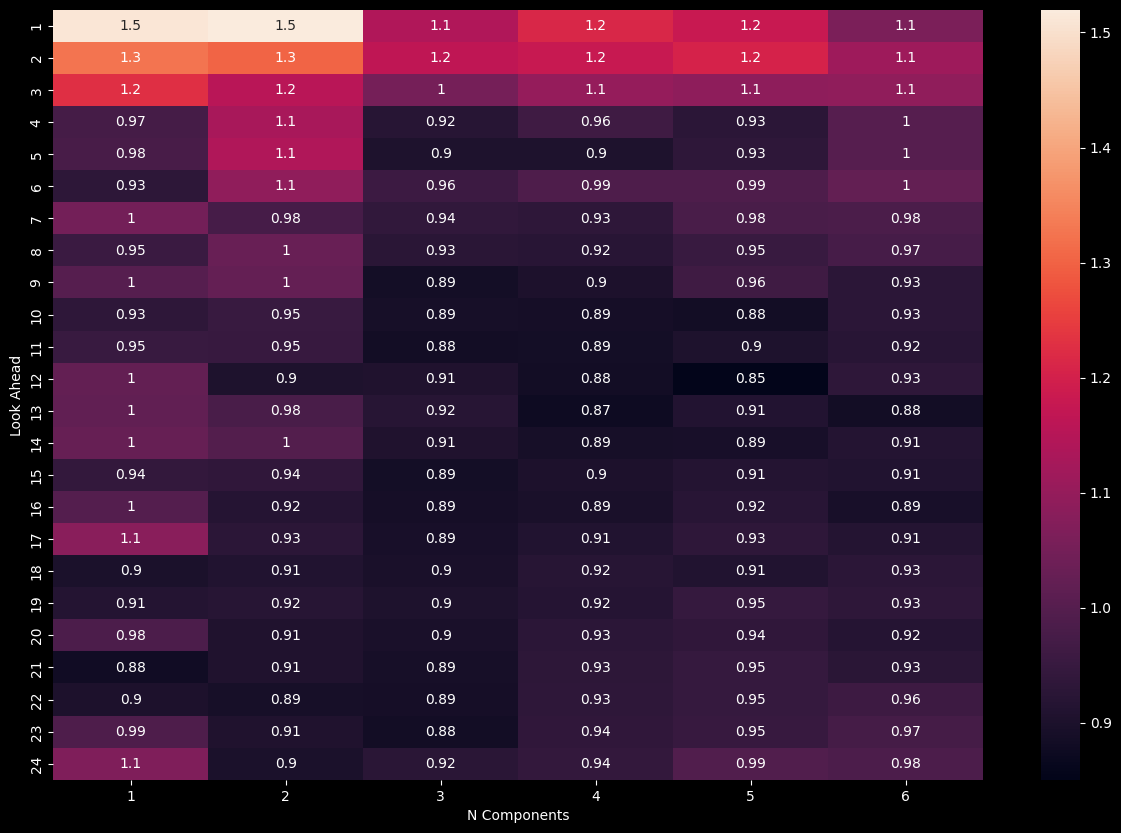

In [27]:
# Heatmap code
next_r = np.log(data['close']).diff().shift(-1)
pf_df = pd.DataFrame()
for lookahead in list(range(1, 25)):
    for n_components in [1,2,3,4,5,6]:
        output = pca_rsi_model(data, list(range(2, 25)), 24 * 365 * 2, 24 * 365, n_components=n_components, lookahead=lookahead)
        output['t'] = np.log(data['close']).diff(lookahead).shift(-lookahead)
        data['strat_ret'] = next_r * output['signal']

        # Profit fac
        pf = data[data['strat_ret'] > 0]['strat_ret'].sum() / data[data['strat_ret'] < 0]['strat_ret'].abs().sum()
        print(pf)

        pf_df.loc[lookahead, n_components] = pf

plt.figure(figsize=(15, 10))  # You can adjust the numbers to fit your specific needs
plt.style.use('dark_background')
sns.heatmap(pf_df, annot=True)
plt.xlabel("N Components")
plt.ylabel("Look Ahead")